<h1 style="text-align: center;"> Fortune Finders: the living wage expedition </h1>
<h2 style="text-align: center;"> Empowering workers with concrete data to support fair salary negotiations.</h2>

<h3> Introduction </h3>

To achieve the goal specified above this notebook will utilize and cross examine, the data tables<br/>  from the MIT Living Wage Calculator with Census and BEA data. We will compare typical salaries<br/> by industry and state (adjusted for price parity) with living wage data to anwer the following questions: 
1. Which regions (state, county, Metro-city) offers the best salary-to-living-wage ratio for a typical industry?
1. How do do the ratios vary between geographic locations and occupations?

<a id = "toc"></a>
### Table of Contents
- [Imports and Raw Data Preview](#Topic0)
    - [Imports](#Topic01)
    - [Raw Data Preview](#Topic02)
- [MIT Data with Population](#Topic1)
    - [Census Population Data Clean and Prep](#Topic11)
    - [MIT Tables Merged With Census Populations](#Topic12)
- [MIT Data State Summaries](#Topic2)

<a id = "Topic0"></a> 

### Imports and Raw Data Preview
#### Imports

In [24]:
# version = 3.11.4

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

import pandas as pd
from IPython.display import display, Markdown
import numpy as np
from numpy.random import randint
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import altair as alt
from matplotlib import gridspec

# Set up choropleth map
geojson_path = '../data/ne_110m_admin_1_states_provinces.shp'
states = gpd.read_file(geojson_path)
states = states.to_crs("EPSG:3395")


In [25]:
#BEA Data brought in here as csv to protect our API key
RPP = pd.read_csv('../price_parities.csv') #BEA Price parities: SARPP Table
StateSalary = pd.read_csv('../personal_income.csv') #Average State Salary: SAINC5N Report
SSRPP = pd.read_csv('../combined.csv') #Average State Salary adjusted by RPP

#MIT Living Wage Data
CostDF = pd.read_csv('../CostDF.csv')
SalaryDF = pd.read_csv('../SalaryDF.csv')
WageDF = pd.read_csv('../WageDF.csv')

for d in [CostDF, SalaryDF, WageDF]:
    d.drop(['Unnamed: 0'], axis=1,inplace=True)

#Census Data CountyPopUSCensus or CPUC
 
CPUC = pd.read_excel(
    '../co-est2022-pop.xlsx',
    header = [3],
    skiprows = [4,326,3149,3150,3151,3152,3153]    
    #4: total of whole of united states
    #326: District of Columbia
    #3149-3153: Table footnotes captured below
)
CPUC.columns = ['Geographic Area', 'April 1, 2020 Estimates Base', 'Population Estimate 2020', 'Population Estimate 2021', 'Population Estimate 2022']

<a id='Topic02'></a> 
#### Raw Data Preview
<a href='#toc'>TOC</a>

In [26]:
Tables = {
    "2022 Price Parities": RPP,
    "2022 Average State Salary": StateSalary,
    "Average State Salary adjusted by RPP":SSRPP,
    "MIT Living Wage: Wages by County":WageDF,
    "MIT Living Wage: Typical Expenses by County":CostDF,
    "MIT Living Wage: Occupation Salary by County":SalaryDF,
    "County Population US Census":CPUC
    }

for title, table in Tables.items():
    display(Markdown('<br/><h5>{}</h5>'.format(title)))

    rows = 5
    if "Wages" in title:
        rows = 3
    if "Expenses" in title:
        rows = 10
    if "Occupation" in title:
        rows =  22
    display(table.head(rows))

<br/><h5>2022 Price Parities</h5>

,Code,GeoFips,GeoName,TimePeriod,CL_UNIT,UNIT_MULT,DataValue
0,SARPP-1,0,United States,2022,Index,0,100.000
1,SARPP-1,1000,Alabama,2022,Index,0,87.776
2,SARPP-1,2000,Alaska,2022,Index,0,101.989
3,SARPP-1,4000,Arizona,2022,Index,0,99.897
4,SARPP-1,5000,Arkansas,2022,Index,0,86.597


<br/><h5>2022 Average State Salary</h5>

,Code,GeoFips,GeoName,TimePeriod,CL_UNIT,UNIT_MULT,DataValue,NoteRef
0,SAINC5N-30,0,United States,2022,Dollars,0,65470,3
1,SAINC5N-30,1000,Alabama,2022,Dollars,0,50916,3
2,SAINC5N-30,2000,Alaska,2022,Dollars,0,68635,3
3,SAINC5N-30,4000,Arizona,2022,Dollars,0,58442,3
4,SAINC5N-30,5000,Arkansas,2022,Dollars,0,52618,3


<br/><h5>Average State Salary adjusted by RPP</h5>

,State,Year,Income,Price Parities,Standardized Income
0,Wyoming,2022,73248.0,91.903,79701.42
1,North Dakota,2022,70360.0,88.656,79362.93
2,Connecticut,2022,82938.0,106.412,77940.46
3,South Dakota,2022,68176.0,87.991,77480.65
4,Massachusetts,2022,84561.0,109.393,77300.19


<br/><h5>MIT Living Wage: Wages by County</h5>

,WageType,1 ADULT - 0,1 ADULT - 1,1 ADULT - 2,1 ADULT - 3,2 ADULTS(1 WORKING) - 0,2 ADULTS(1 WORKING) - 1,2 ADULTS(1 WORKING) - 2,2 ADULTS(1 WORKING) - 3,2 ADULTS(BOTH WORKING) - 0,2 ADULTS(BOTH WORKING) - 1,2 ADULTS(BOTH WORKING) - 2,2 ADULTS(BOTH WORKING) - 3,State,County
0,Living Wage,$16.04,$30.58,$37.60,$48.71,$25.52,$30.31,$35.73,$38.52,$12.76,$17.01,$21.58,$24.83,Alabama,Autauga
1,Poverty Wage,$6.19,$8.38,$10.56,$12.74,$8.38,$10.56,$12.74,$14.92,$4.19,$5.28,$6.37,$7.46,Alabama,Autauga
2,Minimum Wage,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,Alabama,Autauga


<br/><h5>MIT Living Wage: Typical Expenses by County</h5>

,CostType,1 ADULT - 0,1 ADULT - 1,1 ADULT - 2,1 ADULT - 3,2 ADULTS(1 WORKING) - 0,2 ADULTS(1 WORKING) - 1,2 ADULTS(1 WORKING) - 2,2 ADULTS(1 WORKING) - 3,2 ADULTS(BOTH WORKING) - 0,2 ADULTS(BOTH WORKING) - 1,2 ADULTS(BOTH WORKING) - 2,2 ADULTS(BOTH WORKING) - 3,State,County
0,Food,"$3,351","$4,937","$7,417","$9,838","$6,143","$7,645","$9,856","$11,999","$6,143","$7,645","$9,856","$11,999",Alabama,Autauga
1,Child Care,$0,"$6,261","$12,521","$18,782",$0,$0,$0,$0,$0,"$6,261","$12,521","$18,782",Alabama,Autauga
2,Medical,"$2,733","$7,921","$7,708","$8,018","$6,298","$7,708","$8,018","$7,807","$6,298","$7,708","$8,018","$7,807",Alabama,Autauga
3,Housing,"$8,310","$11,789","$11,789","$14,906","$9,946","$11,789","$11,789","$14,906","$9,946","$11,789","$11,789","$14,906",Alabama,Autauga
4,Transportation,"$5,509","$9,776","$12,709","$15,012","$9,776","$12,709","$15,012","$16,304","$9,776","$12,709","$15,012","$16,304",Alabama,Autauga
5,Civic,"$2,503","$4,019","$4,965","$6,483","$4,019","$4,965","$6,483","$5,153","$4,019","$4,965","$6,483","$5,153",Alabama,Autauga
6,Other,"$4,508","$6,723","$6,150","$8,948","$6,723","$6,150","$8,948","$8,655","$6,723","$6,150","$8,948","$8,655",Alabama,Autauga
7,Required annual income after taxes,"$27,036","$51,550","$63,383","$82,110","$43,027","$51,090","$60,230","$64,946","$43,027","$57,351","$72,751","$83,728",Alabama,Autauga
8,Annual taxes,"$6,321","$12,053","$14,819","$19,198","$10,060","$11,945","$14,082","$15,185","$10,060","$13,409","$17,010","$19,576",Alabama,Autauga
9,Required annual income before taxes,"$33,357","$63,602","$78,203","$101,308","$53,087","$63,035","$74,312","$80,131","$53,087","$70,760","$89,760","$103,304",Alabama,Autauga


<br/><h5>MIT Living Wage: Occupation Salary by County</h5>

,Occupational Area,Typical Annual Salary,State,County
0,Management,"$101,778",Alabama,Autauga
1,Business &amp; Financial Operations,"$71,198",Alabama,Autauga
2,Computer &amp; Mathematical,"$86,938",Alabama,Autauga
3,Architecture &amp; Engineering,"$90,447",Alabama,Autauga
4,"Life, Physical, &amp; Social Science","$64,992",Alabama,Autauga
5,Community &amp; Social Service,"$47,059",Alabama,Autauga
6,Legal,"$69,240",Alabama,Autauga
7,"Education, Training, &amp; Library","$54,260",Alabama,Autauga
8,"Arts, Design, Entertainment, Sports, &amp; Media","$41,698",Alabama,Autauga
9,Healthcare Practitioners &amp; Technical,"$58,080",Alabama,Autauga


<br/><h5>County Population US Census</h5>

,Geographic Area,"April 1, 2020 Estimates Base",Population Estimate 2020,Population Estimate 2021,Population Estimate 2022
0,".Autauga County, Alabama",58802,58902,59210,59759
1,".Baldwin County, Alabama",231761,233219,239361,246435
2,".Barbour County, Alabama",25224,24960,24539,24706
3,".Bibb County, Alabama",22300,22183,22370,22005
4,".Blount County, Alabama",59130,59102,59085,59512


<a id = "Topic1"></a>

### MIT Data with Population
#### Add county populations
*Population via Census merged to MIT Tables:
Cost, Salary and Wage tables from the MIT Living Wage Data set will be combined with county population via Census

<a id = "Topic11"></a>

#### Clean up CPUC for merge
1. define split function
2. split data
3. check for missing rows between MIT data and Census
4. examine  differences, revisit and modify step 2 until all MIT rows match
5. Inner merge MIT Table and CPUC Tables

<a href='#toc'>TOC</a>

In [27]:
# Function to split the 'Geographic Area'[column in CPUC] into 'County' and 'State'
def split_geographic_area(area):
    
    area_cleaned = area.strip('.').strip() # Strip leading periods and whitespace    
    parts = area_cleaned.split(',') # Most pairs have format [County equivalent],[state]
    
    # If there's no comma or an unexpected format, return placeholders indicating a need for manual review
    if len(parts) != 2:
        return ['Invalid Format - Review Needed', 'Invalid Format - Review Needed']
    # Trim whitespace from parts to ensure clean data
    county, state = parts[0].strip(), parts[1].strip()
    return county, state

In [28]:
CPUC_1 = CPUC.copy() #maintain original 

#split the 'Geographic Area' into 'County' and 'State'
CPUC_1[['County Equivalent', 'State']] = CPUC_1.apply(lambda row: split_geographic_area(row['Geographic Area']), axis=1, result_type='expand')
#merge destination has the word "County stripped from county entries (although maintains other title like "Parish")"
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(' County', '', regex=False) 
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(' Borough', '', regex=False) 
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(' Census Area', '', regex=False)
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(' Parish', '', regex=False) 
CPUC_1['County Equivalent'] = CPUC_1['County Equivalent'].str.replace(' Planning Region', '', regex=False)

#Connecticut uses regions instead of counties we'll approximately correct for this
CT_rename_map={
    "Northwest Hills": "Litchfield",
    "Naugatuck Valley": "New Haven",
    "South Central Connecticut": "New Haven",
    "Western Connecticut": "Fairfield",
    "Greater Bridgeport": "Fairfield",
    "Lower Connecticut River Valley": "Middlesex",
    "Southeastern Connecticut": "New London",
    "Northeastern Connecticut": "Windham"
}

for old_name, new_name in CT_rename_map.items():
    CPUC_1.loc[(CPUC_1['State'] == 'Connecticut') & (CPUC_1['County Equivalent'].str.contains(old_name, case=False)), 'County Equivalent'] = new_name

# Connecticut census combines Tolland and Haartford counties. I'm going to drop capitol and manualy add them
CPUC_1 = CPUC_1[~((CPUC_1['County Equivalent'] == 'Capitol') & (CPUC_1['State'] == 'Connecticut'))]

# Add new entries for Hartford and Tolland
new_rows = pd.DataFrame([
    [".Hartford County, Connecticut", 897932, 897932, 898636, 898636, "Hartford", "Connecticut"],
    [".Tolland County, Connecticut", 149650, 149650, 150293, 150120, "Tolland", "Connecticut"]
], columns=['Geographic Area', 'April 1, 2020 Estimates Base', 'Population Estimate 2020', 'Population Estimate 2021', 'Population Estimate 2022', 'County Equivalent', 'State'])

CPUC_1 = pd.concat([CPUC_1, new_rows], ignore_index=True)

#Alaska corrections
AK_rename_map={
    "Anchorage Municipality": "Valdez-Cordova",
    "Chugach": "Valdez-Cordova",
    "Copper River": "Valdez-Cordova"
} 

for old_name, new_name in AK_rename_map.items():
    CPUC_1.loc[(CPUC_1['State'] == 'Alaska') & (CPUC_1['County Equivalent'].str.contains(old_name, case=False)), 'County Equivalent'] = new_name


#Virginia Corrections
VI_rename_map={
    "Alexandria city" : "Alexandria",
    "Bristol city" : "Bristol",
    "Buena Vista city" : "Buena Vista",
    "Charlottesville city" : "Charlottesville",
    "Chesapeake city" : "Chesapeake",
    "Colonial Heights city" : "Colonial Heights",
    "Covington city" : "Covington",
    "Danville city" : "Danville",
    "Emporia city" : "Emporia",
    "Falls Church city" : "Falls Church",
    "Fredericksburg city" : "Fredericksburg",
    "Galax city" : "Galax",
    "Hampton city" : "Hampton",
    "Harrisonburg city" : "Harrisonburg",
    "Hopewell city" : "Hopewell",
    "Lexington city" : "Lexington",
    "Lynchburg city" : "Lynchburg",
    "Manassas Park city" : "Manassas Park",
    "Manassas city" : "Manassas",
    "Martinsville city" : "Martinsville",
    "Newport News city" : "Newport News",
    "Norfolk city" : "Norfolk",
    "Norton city" : "Norton",
    "Petersburg city" : "Petersburg",
    "Radford city" : "Poquoson",
    "Richmond city" : "Portsmouth",
    "Roanoke city" : "Radford",
    "Salem city" : "Salem",
    "Staunton city" : "Staunton",
    "Suffolk city" : "Suffolk",
    "Virginia Beach city" : "Virginia Beach",
    "Waynesboro city" : "Waynesboro",
    "Williamsburg city" : "Williamsburg",
    "Winchester city" : "Winchester"
}

for old_name, new_name in VI_rename_map.items():
    CPUC_1.loc[(CPUC_1['State'] == 'Virginia') & (CPUC_1['County Equivalent'].str.contains(old_name, case=False)), 'County Equivalent'] = new_name


#duplicates now exist form some counties lets aggregate
aggregated_df = CPUC_1.groupby(['County Equivalent', 'State']).agg({
    'April 1, 2020 Estimates Base': 'sum',
    'Population Estimate 2020': 'sum',
    'Population Estimate 2021': 'sum',
    'Population Estimate 2022': 'sum'
}).reset_index()
aggregated_df['Geographic Area'] = aggregated_df['County Equivalent'] + " , " + aggregated_df['State']
aggregated_df = aggregated_df[['Geographic Area', 'April 1, 2020 Estimates Base', 'Population Estimate 2020', 'Population Estimate 2021', 'Population Estimate 2022', 'County Equivalent', 'State']]
CPUC_1 = aggregated_df



CPUC_1_Invalid = len( CPUC_1[CPUC_1['County Equivalent'] == 'Invalid Format - Review Needed' ])
CPUC_1_Valid = len(CPUC) - CPUC_1_Invalid

print(f'Number of total counties: {len(CPUC_1)}')
print(f'Number of valid county-state splits: {CPUC_1_Valid}')
print(f'Number of invalid county-state splits: {CPUC_1_Invalid}')

CPUC_1.head(20)

Number of total counties: 3140
Number of valid county-state splits: 3143
Number of invalid county-state splits: 0


,Geographic Area,"April 1, 2020 Estimates Base",Population Estimate 2020,Population Estimate 2021,Population Estimate 2022,County Equivalent,State
0,"Abbeville , South Carolina",24287,24256,24258,24356,Abbeville,South Carolina
1,"Acadia , Louisiana",57569,57472,57262,56744,Acadia,Louisiana
2,"Accomack , Virginia",33417,33388,33364,33191,Accomack,Virginia
3,"Ada , Idaho",494964,498260,512914,518907,Ada,Idaho
4,"Adair , Iowa",7498,7494,7538,7494,Adair,Iowa
5,"Adair , Kentucky",18903,18880,18953,19067,Adair,Kentucky
6,"Adair , Missouri",25315,25269,25179,25165,Adair,Missouri
7,"Adair , Oklahoma",19494,19451,19479,19576,Adair,Oklahoma
8,"Adams , Colorado",519582,520479,523592,527575,Adams,Colorado
9,"Adams , Idaho",4380,4425,4632,4817,Adams,Idaho


In [29]:
# we will merge several dfs on state and county
# lets examine thier sizes 
print(f'WageDF has {len(WageDF[["County", "State"]].copy().drop_duplicates())} counties')
print(f'CostDF has {len(CostDF[["County", "State"]].copy().drop_duplicates())} counties')
print(f'SalaryDF has {len(SalaryDF[["County", "State"]].copy().drop_duplicates())} counties')


WageDF has 3115 counties
CostDF has 3115 counties
SalaryDF has 3115 counties


In [30]:
# lets examine missing pairings
# Create unique state-county identifiers for each dataset
WageDF['State-County'] = WageDF['State'] + '-' + WageDF['County']
CPUC_1['State-County'] = CPUC_1['State'] + '-' + CPUC_1['County Equivalent']

wage_unique_pairings = set(WageDF['State-County'])
census_unique_pairings = set(CPUC_1['State-County'])
merged_unique_pairings = set(WageDF['State'] + '-' + WageDF['County']) & set(CPUC_1['State'] + '-' + CPUC_1['County Equivalent'])

# Identify missing pairings in merged_df from both wage_df and census_df_cleaned
missing_in_merged_from_wage = wage_unique_pairings - merged_unique_pairings
missing_in_merged_from_census = census_unique_pairings - merged_unique_pairings

# Filter wage_df and census_df_cleaned for the missing pairings
missing_rows_wage_df = WageDF[WageDF['State-County'].isin(missing_in_merged_from_wage)]
missing_rows_census_df_cleaned = CPUC_1[CPUC_1['State-County'].isin(missing_in_merged_from_census)]



#Display the count of missing rows for each dataset to understand the scope
M_MIT = missing_rows_wage_df[["County", "State"]].copy().drop_duplicates()
M_CPUC = missing_rows_census_df_cleaned[["County Equivalent", "State"]].copy().drop_duplicates()

#from here we'll compare and loop back to and modify CPUC_1 definition until all counties from wage_df are matched
display(Markdown('<br/><h5>{}: {}</h5>'.format("Unmatched MIT counties", len(M_MIT))))
display(M_MIT.head(30))
display(Markdown('<br/><h5>{}: {}</h5>'.format("Unmatched Census counties", len(M_CPUC))))
display(M_CPUC.head(30))

<br/><h5>Unmatched MIT counties: 0</h5>

,County,State


<br/><h5>Unmatched Census counties: 25</h5>

,County Equivalent,State
122,Baltimore city,Maryland
271,Bristol,Rhode Island
815,Doña Ana,New Mexico
840,Echols,Georgia
895,Fairfax city,Virginia
976,Franklin city,Virginia
1073,Grand Isle,Vermont
1383,James City,Virginia
1457,Juneau City and,Alaska
1460,Kalawao,Hawaii


Our dataset is missing some counties and we're unable to reconcile them. The original MIT data for this analysis came from a data pull in May 2022. Since that pull it has been noticed on the MIT Living Wage Calculator website that they request no web scrapping. We submitted a request to thier API but haven't heard back likely due to the fact they update thier tables yearly in January. As such we will use the data we have and respect thier wishes. The data is still public and could be grabbed table by table without the API via copy paste. So we press on to merge the data

<a name = "Topic12"></a>

### MIT Data With Population Tables

<a href='#toc'>TOC</a>

In [39]:
CPUC_1 = CPUC_1[["Population Estimate 2022","County Equivalent", "State"]]

WageDFwithPop = pd.merge(CPUC_1, WageDF, left_on=['State', 'County Equivalent'], right_on=['State', 'County'], how='inner')
CostDFwithPop = pd.merge(CPUC_1, CostDF, left_on=['State', 'County Equivalent'], right_on=['State', 'County'], how='inner')
SalaryDFwithPop = pd.merge(CPUC_1, SalaryDF, left_on=['State', 'County Equivalent'], right_on=['State', 'County'], how='inner')

WageDFwithPop.to_csv('WageDFwithPop.csv') 
CostDFwithPop.to_csv('CostDFwithPop.csv') 


print(WageDFwithPop['State'].unique())
print(CostDFwithPop['State'].unique())
print(SalaryDFwithPop['State'].unique())
display(Markdown('<br/><h5>{}</h5>'.format("MIT Living Wage: Wages by County and Population")))
display(WageDFwithPop.head(3))
display(Markdown('<br/><h5>{}</h5>'.format("MIT Living Wage: Typical Expenses by County and Population")))
display(CostDFwithPop.head(10))
display(Markdown('<br/><h5>{}</h5>'.format("MIT Living Wage: Occupation Salary by County and Population")))
display(SalaryDFwithPop.head(22))



['South Carolina' 'Louisiana' 'Virginia' 'Idaho' 'Iowa' 'Kentucky'
 'Missouri' 'Oklahoma' 'Colorado' 'Illinois' 'Indiana' 'Mississippi'
 'Nebraska' 'North Dakota' 'Ohio' 'Pennsylvania' 'Washington' 'Wisconsin'
 'Vermont' 'Minnesota' 'Florida' 'North Carolina' 'California' 'New York'
 'Wyoming' 'Michigan' 'Alaska' 'Maryland' 'Kansas' 'Tennessee' 'Texas'
 'Maine' 'Arizona' 'Georgia' 'Arkansas' 'New Jersey' 'South Dakota'
 'Alabama' 'Oregon' 'West Virginia' 'Massachusetts' 'Utah' 'Montana'
 'New Hampshire' 'New Mexico' 'Nevada' 'Connecticut' 'Hawaii' 'Delaware'
 'Rhode Island']
['South Carolina' 'Louisiana' 'Virginia' 'Idaho' 'Iowa' 'Kentucky'
 'Missouri' 'Oklahoma' 'Colorado' 'Illinois' 'Indiana' 'Mississippi'
 'Nebraska' 'North Dakota' 'Ohio' 'Pennsylvania' 'Washington' 'Wisconsin'
 'Vermont' 'Minnesota' 'Florida' 'North Carolina' 'California' 'New York'
 'Wyoming' 'Michigan' 'Alaska' 'Maryland' 'Kansas' 'Tennessee' 'Texas'
 'Maine' 'Arizona' 'Georgia' 'Arkansas' 'New Jersey' 'South Dak

<br/><h5>MIT Living Wage: Wages by County and Population</h5>

,Population Estimate 2022,County Equivalent,State,WageType,1 ADULT - 0,1 ADULT - 1,1 ADULT - 2,1 ADULT - 3,2 ADULTS(1 WORKING) - 0,2 ADULTS(1 WORKING) - 1,2 ADULTS(1 WORKING) - 2,2 ADULTS(1 WORKING) - 3,2 ADULTS(BOTH WORKING) - 0,2 ADULTS(BOTH WORKING) - 1,2 ADULTS(BOTH WORKING) - 2,2 ADULTS(BOTH WORKING) - 3,County,State-County
0,24356,Abbeville,South Carolina,Living Wage,$15.57,$29.48,$35.86,$46.84,$24.67,$30.03,$35.59,$38.88,$12.33,$16.51,$20.78,$23.91,Abbeville,South Carolina-Abbeville
1,24356,Abbeville,South Carolina,Poverty Wage,$6.19,$8.38,$10.56,$12.74,$8.38,$10.56,$12.74,$14.92,$4.19,$5.28,$6.37,$7.46,Abbeville,South Carolina-Abbeville
2,24356,Abbeville,South Carolina,Minimum Wage,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,$7.25,Abbeville,South Carolina-Abbeville


<br/><h5>MIT Living Wage: Typical Expenses by County and Population</h5>

,Population Estimate 2022,County Equivalent,State,CostType,1 ADULT - 0,1 ADULT - 1,1 ADULT - 2,1 ADULT - 3,2 ADULTS(1 WORKING) - 0,2 ADULTS(1 WORKING) - 1,2 ADULTS(1 WORKING) - 2,2 ADULTS(1 WORKING) - 3,2 ADULTS(BOTH WORKING) - 0,2 ADULTS(BOTH WORKING) - 1,2 ADULTS(BOTH WORKING) - 2,2 ADULTS(BOTH WORKING) - 3,County
0,24356,Abbeville,South Carolina,Food,"$3,351","$4,937","$7,417","$9,838","$6,143","$7,645","$9,856","$11,999","$6,143","$7,645","$9,856","$11,999",Abbeville
1,24356,Abbeville,South Carolina,Child Care,$0,"$4,903","$9,805","$14,708",$0,$0,$0,$0,$0,"$4,903","$9,805","$14,708",Abbeville
2,24356,Abbeville,South Carolina,Medical,"$2,957","$9,182","$8,969","$9,278","$7,086","$8,969","$9,278","$9,067","$7,086","$8,969","$9,278","$9,067",Abbeville
3,24356,Abbeville,South Carolina,Housing,"$6,648","$8,816","$8,816","$12,620","$6,687","$8,816","$8,816","$12,620","$6,687","$8,816","$8,816","$12,620",Abbeville
4,24356,Abbeville,South Carolina,Transportation,"$5,509","$9,776","$12,709","$15,012","$9,776","$12,709","$15,012","$16,304","$9,776","$12,709","$15,012","$16,304",Abbeville
5,24356,Abbeville,South Carolina,Civic,"$2,503","$4,019","$4,965","$6,483","$4,019","$4,965","$6,483","$5,153","$4,019","$4,965","$6,483","$5,153",Abbeville
6,24356,Abbeville,South Carolina,Other,"$4,508","$6,723","$6,150","$8,948","$6,723","$6,150","$8,948","$8,655","$6,723","$6,150","$8,948","$8,655",Abbeville
7,24356,Abbeville,South Carolina,Required annual income after taxes,"$25,599","$48,479","$58,955","$77,011","$40,556","$49,377","$58,517","$63,922","$40,556","$54,280","$68,322","$78,630",Abbeville
8,24356,Abbeville,South Carolina,Annual taxes,"$6,784","$12,848","$15,624","$20,410","$10,748","$13,086","$15,508","$16,941","$10,748","$14,385","$18,107","$20,839",Abbeville
9,24356,Abbeville,South Carolina,Required annual income before taxes,"$32,383","$61,327","$74,579","$97,421","$51,304","$62,463","$74,025","$80,862","$51,304","$68,666","$86,429","$99,468",Abbeville


<br/><h5>MIT Living Wage: Occupation Salary by County and Population</h5>

,Population Estimate 2022,County Equivalent,State,Occupational Area,Typical Annual Salary,County
0,24356,Abbeville,South Carolina,Management,"$101,928",Abbeville
1,24356,Abbeville,South Carolina,Business &amp; Financial Operations,"$67,464",Abbeville
2,24356,Abbeville,South Carolina,Computer &amp; Mathematical,"$77,329",Abbeville
3,24356,Abbeville,South Carolina,Architecture &amp; Engineering,"$80,999",Abbeville
4,24356,Abbeville,South Carolina,"Life, Physical, &amp; Social Science","$64,457",Abbeville
5,24356,Abbeville,South Carolina,Community &amp; Social Service,"$42,212",Abbeville
6,24356,Abbeville,South Carolina,Legal,"$62,777",Abbeville
7,24356,Abbeville,South Carolina,"Education, Training, &amp; Library","$49,958",Abbeville
8,24356,Abbeville,South Carolina,"Arts, Design, Entertainment, Sports, &amp; Media","$45,250",Abbeville
9,24356,Abbeville,South Carolina,Healthcare Practitioners &amp; Technical,"$65,891",Abbeville


<a id = Topic2></a>

### MIT Data State Summaries
#### County data Projected up to state level
*weighting projection by county population

<a href='#toc'>TOC</a>

#### State Data Aggregation for cost and wage

In [32]:
StateNames = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 
              'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 
              'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
              'Maine', 'Maryland', 'Massachusetts','Michigan', 'Minnesota',
              'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 
              'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
              'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 
              'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 
              'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 
              'Wisconsin', 'Wyoming']

In [33]:
CostDFwithPop.drop(['County Equivalent',],axis=1,inplace=True)
NewCostDF = pd.DataFrame(columns = CostDFwithPop.columns)
NewCostDF.drop(['County',"Population Estimate 2022"],axis=1,inplace=True)
for state in StateNames:
    Dfstate = CostDFwithPop.where(CostDFwithPop['State'] == state).dropna(subset='State')
    StatePopSum = Dfstate.copy().drop_duplicates('County')
    SPSum = np.sum(StatePopSum["Population Estimate 2022"])   
    CountyList = set(list(Dfstate['County']))

    #initialize aggregation dataframe
    NewStateDF = pd.DataFrame(columns = Dfstate.columns)
    NewStateDF.drop(['State','County',"Population Estimate 2022"],axis=1,inplace=True)
    
    # process cost data for each county, adjusting by population weight
    for county in CountyList:
        countyweight = StatePopSum.where(StatePopSum['County'] == county).dropna(subset='County')["Population Estimate 2022"]
        countyweight = float(countyweight/SPSum)
        #if state == 'West Virginia':
        #    print(countyweight)
        countyDF = Dfstate.where(Dfstate['County'] == county).dropna(subset='County')
        countyDF.drop(['State','County',"Population Estimate 2022"],axis=1,inplace=True)
        toconcat = pd.DataFrame(columns = countyDF.columns)
        countyDF.set_index('CostType',inplace=True)
        for column in countyDF.columns:
            countyDF[column] = countyDF[column].apply(lambda x: str(x[1:]))
            countyDF[column] = countyDF[column].str.replace(',', '')
            countyDF[column] = countyDF[column].apply(lambda x: int(x)*countyweight)
        countyDF.reset_index(inplace=True) #was automatically named CostType
        toconcat = pd.concat([toconcat,countyDF])
        NewStateDF = pd.concat([NewStateDF,toconcat])

    # aggregates the data at the state level by cost type           
    NewStateDF = NewStateDF.groupby('CostType').sum()
    NewStateDF.reset_index(inplace=True)
    
    #Append the processed state data to the new DataFrame
    StateCostDF = pd.concat([NewCostDF,NewStateDF])

In [34]:
WageDFwithPop.drop(['County Equivalent','State-County'],axis=1,inplace=True)
NewWageDF = pd.DataFrame(columns = WageDFwithPop.columns)
NewWageDF.drop(['County',"Population Estimate 2022"],axis=1,inplace=True)
for state in StateNames:
    Dfstate = WageDFwithPop.where(WageDFwithPop['State'] == state).dropna(subset='State')
    StatePopSum = Dfstate.copy().drop_duplicates('County')
    SPSum = np.sum(StatePopSum["Population Estimate 2022"])
    CountyList = set(list(Dfstate['County']))
    NewStateDF = pd.DataFrame(columns = Dfstate.columns)
    NewStateDF.drop(['State','County',"Population Estimate 2022"],axis=1,inplace=True)
    for county in CountyList:
        countyweight = StatePopSum.where(StatePopSum['County'] == county).dropna(subset='County')["Population Estimate 2022"]
        countyweight = float(countyweight/SPSum)
        countyDF = Dfstate.where(Dfstate['County'] == county).dropna(subset='County')
        countyDF.drop(['State','County',"Population Estimate 2022"],axis=1,inplace=True)
        toconcat = pd.DataFrame(columns = countyDF.columns)
        countyDF.set_index('WageType',inplace=True)
        for column in countyDF.columns:
            countyDF[column] = countyDF[column].apply(lambda x: str(x[1:]))
            countyDF[column] = countyDF[column].str.replace(',', '')
            countyDF[column] = countyDF[column].apply(lambda x: float(x.strip())*countyweight)
        countyDF.reset_index(inplace=True)
        toconcat = pd.concat([toconcat,countyDF])
        NewStateDF = pd.concat([NewStateDF,toconcat])
        #break
    NewStateDF = NewStateDF.groupby('WageType').sum()
    NewStateDF.reset_index(inplace=True)
    NewStateDF['State'] = state
    StateWageDF = pd.concat([NewWageDF,NewStateDF])

#### State Salary Data
One thing we'd come to find out is that salaries arn't estimated by occupation at the county level, instead the statewide estimates are reiteriated for each county. We feel this finding is related to the ethics issues we raised in our proposal. There are some rual counties in the USA where very few individuals work in certain occupations. It's likely the MIT team didn't drill down into county level data here due to privacy concerns. It is possible this data could be aggregated  through a combination of unsupervised and supervised learning combined with BLS statistics however, If the MIT team didn't do it we probably shouldn't either.

In [35]:
StateSalary = SalaryDFwithPop.copy()
StateSalary['Typical Annual Salary'] = StateSalary['Typical Annual Salary'].str.strip().str.replace(',', '').str.replace('$', '').astype(int)
StateSalary.head()
StateSalary = StateSalary.groupby(['State', 'Occupational Area']).agg({'Population Estimate 2022': 'sum', 'Typical Annual Salary': 'sum', 'Typical Annual Salary': lambda x: sum(x * SalaryDFwithPop.loc[x.index, 'Population Estimate 2022']) / sum(SalaryDFwithPop.loc[x.index, 'Population Estimate 2022'])}).reset_index()



#### MIT State Summary Tables

In [36]:
print(StateWageDF['State'].unique())
print(StateCostDF['State'].unique())
print(StateSalary['State'].unique())
display(Markdown('<br/><h5>{}</h5>'.format("MIT Living Wage: Wages by State and Population")))
display(StateWageDF.head(3))
display(Markdown('<br/><h5>{}</h5>'.format("MIT Living Wage: Typical Expenses by State and Population")))
display(StateCostDF.head(10))
display(Markdown('<br/><h5>{}</h5>'.format("MIT Living Wage: Occupation Salary by State and Population")))
display(StateSalary.head(22))

['Wyoming']
[nan]
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


<br/><h5>MIT Living Wage: Wages by State and Population</h5>

,State,WageType,1 ADULT - 0,1 ADULT - 1,1 ADULT - 2,1 ADULT - 3,2 ADULTS(1 WORKING) - 0,2 ADULTS(1 WORKING) - 1,2 ADULTS(1 WORKING) - 2,2 ADULTS(1 WORKING) - 3,2 ADULTS(BOTH WORKING) - 0,2 ADULTS(BOTH WORKING) - 1,2 ADULTS(BOTH WORKING) - 2,2 ADULTS(BOTH WORKING) - 3
0,Wyoming,Living Wage,15.253858,29.901198,37.815798,50.395964,23.63109,28.56013,33.880809,37.317655,11.8164,16.630647,21.644851,25.713826
1,Wyoming,Minimum Wage,7.250000,7.250000,7.250000,7.250000,7.25000,7.25000,7.250000,7.250000,7.2500,7.250000,7.250000,7.250000
2,Wyoming,Poverty Wage,6.190000,8.380000,10.560000,12.740000,8.38000,10.56000,12.740000,14.920000,4.1900,5.280000,6.370000,7.460000


<br/><h5>MIT Living Wage: Typical Expenses by State and Population</h5>

,State,CostType,1 ADULT - 0,1 ADULT - 1,1 ADULT - 2,1 ADULT - 3,2 ADULTS(1 WORKING) - 0,2 ADULTS(1 WORKING) - 1,2 ADULTS(1 WORKING) - 2,2 ADULTS(1 WORKING) - 3,2 ADULTS(BOTH WORKING) - 0,2 ADULTS(BOTH WORKING) - 1,2 ADULTS(BOTH WORKING) - 2,2 ADULTS(BOTH WORKING) - 3
0,NaN,Annual taxes,4425.948965,8675.873890,10972.154238,14622.991004,6857.103839,8287.162274,9831.281772,10828.207229,6857.103839,9651.792948,12560.492230,14922.066213
1,NaN,Child Care,0.000000,8418.204243,16835.839525,25254.043768,0.000000,0.000000,0.000000,0.000000,0.000000,8418.204243,16835.839525,25254.043768
2,NaN,Civic,2581.000000,4144.000000,5120.000000,6686.000000,4144.000000,5120.000000,6686.000000,5314.000000,4144.000000,5120.000000,6686.000000,5314.000000
3,NaN,Food,3999.000000,5893.000000,8853.000000,11742.000000,7332.000000,9124.000000,11764.000000,14321.000000,7332.000000,9124.000000,11764.000000,14321.000000
4,NaN,Housing,8509.595429,11284.158124,11284.158124,15609.989301,9146.961216,11284.158124,11284.158124,15609.989301,9146.961216,11284.158124,11284.158124,15609.989301
5,NaN,Medical,2402.000000,7811.000000,7598.000000,7907.000000,5709.000000,7598.000000,7907.000000,7696.000000,5709.000000,7598.000000,7907.000000,7696.000000
6,NaN,Other,4748.000000,7080.000000,6477.000000,9424.000000,7080.000000,6477.000000,9424.000000,9115.000000,7080.000000,6477.000000,9424.000000,9115.000000
7,NaN,Required annual income after taxes,27300.711908,53515.832315,67681.997649,90201.203911,42297.675497,51117.666800,60643.122587,66792.622679,42297.675497,59535.871043,77478.962113,92046.666448
8,NaN,Required annual income before taxes,31726.753403,62191.517084,78654.025923,104824.313366,49154.852474,59404.557223,70474.032610,77620.864657,49154.852474,69187.517084,90039.151887,106968.845729
9,NaN,Transportation,4938.000000,8762.000000,11391.000000,13456.000000,8762.000000,11391.000000,13456.000000,14613.000000,8762.000000,11391.000000,13456.000000,14613.000000


<br/><h5>MIT Living Wage: Occupation Salary by State and Population</h5>

,State,Occupational Area,Population Estimate 2022,Typical Annual Salary
0,Alabama,Architecture &amp; Engineering,5074296,90447.0
1,Alabama,"Arts, Design, Entertainment, Sports, &amp; Media",5074296,41698.0
2,Alabama,Building &amp; Grounds Cleaning &amp; Maintenance,5074296,26108.0
3,Alabama,Business &amp; Financial Operations,5074296,71198.0
4,Alabama,Community &amp; Social Service,5074296,47059.0
5,Alabama,Computer &amp; Mathematical,5074296,86938.0
6,Alabama,Construction &amp; Extraction,5074296,42490.0
7,Alabama,"Education, Training, &amp; Library",5074296,54260.0
8,Alabama,"Farming, Fishing, &amp; Forestry",5074296,32132.0
9,Alabama,Food Preparation &amp; Serving Related,5074296,20812.0


## Visuals
### preprocessing

In [37]:
#Data long form
MeltedCosts = pd.melt(StateCostDF, id_vars  = ['State', 'CostType'], var_name='Household', value_name='Cost')
MeltedCosts['Num Adults in Household'] = MeltedCosts['Household'].apply(lambda x: x.split(' ')[0])
MeltedCosts['Num of working Adults in Household'] = MeltedCosts['Household'].apply(lambda x: 1 if '2 ADULTS(1 WORKING)' in x else 2 if '2 ADULTS(BOTH WORKING)' in x else 1)
MeltedCosts['Num of children in Household'] = MeltedCosts['Household'].apply(lambda x: x.split(' ')[-1])
MeltedCosts.drop(MeltedCosts[MeltedCosts['CostType']=='Required annual income after taxes'].index, inplace = True )
MeltedCosts.drop(MeltedCosts[MeltedCosts['CostType']=='Required annual income before taxes'].index, inplace = True )
MeltedCosts.drop('Household', axis = 1, inplace = True)

MeltedWages = pd.melt(StateWageDF, id_vars = ['State', 'WageType'], var_name='Household', value_name='Earnings')
MeltedWages['Num Adults in Household'] = MeltedWages['Household'].apply(lambda x: x.split(' ')[0])
MeltedWages['Num of working Adults in Household'] = MeltedWages['Household'].apply(lambda x: 1 if '2 ADULTS(1 WORKING)' in x else 2 if '2 ADULTS(BOTH WORKING)' in x else 1)
MeltedWages['Num of children in Household'] = MeltedWages['Household'].apply(lambda x: x.split(' ')[-1])
MeltedWages.drop('Household', axis = 1, inplace = True)
# taking wages to annual
MeltedWages['Earnings'] = MeltedWages['Earnings'] * 2080
#adjusting for dual income
MeltedWages.loc[MeltedWages['Num of working Adults in Household'] == 2] *=2


StateSalary['Occupational Area']= StateSalary['Occupational Area'].str.replace('&amp;', 'and', regex=False)
StateSalary.head()


#merging Parity to MIT
CostParity = pd.merge(RPP, MeltedCosts, left_on = 'GeoName', right_on = 'State', how = 'inner')
WageParity = pd.merge(RPP, MeltedWages, left_on = 'GeoName', right_on = 'State', how = 'inner')
OccupationParity = pd.merge(RPP, StateSalary, left_on = 'GeoName', right_on = 'State', how = 'inner')

#standardizing $ by parity
IVP_Cost = CostParity.rename({'DataValue': 'RPP'}, axis = 'columns')
IVP_Cost["std Costs"] = (IVP_Cost["Cost"] / (IVP_Cost["RPP"]/100)).round(2)
IVP_Cost.sort_values(by="std Costs", ascending=False, inplace=True)

IVP_Wage = WageParity.rename({'DataValue':'RPP'}, axis = 'columns')
IVP_Wage["std wages"] = (IVP_Wage["Earnings"] / (IVP_Wage["RPP"]/100)).round(2)
IVP_Wage.sort_values(by="std wages", ascending=False, inplace=True)

IVP_OCC = OccupationParity.rename({'DataValue':'RPP'}, axis = 'columns')
IVP_OCC["std Salaries"] = (IVP_OCC["Typical Annual Salary"] / (IVP_OCC["RPP"]/100)).round(2)
IVP_OCC.sort_values(by="std Salaries", ascending=False, inplace=True)

#Total Household expenditures
IVP_Cost_Total = IVP_Cost.groupby(['State','Num Adults in Household', 'Num of working Adults in Household','Num of children in Household' ]).agg({'std Costs': 'sum'}).reset_index()

#merge total expenditures with Wage and compare via divison across all households
WageVCost = pd.merge(IVP_Wage, IVP_Cost_Total, left_on = ['State','Num Adults in Household', 'Num of working Adults in Household','Num of children in Household' ], right_on = ['State','Num Adults in Household', 'Num of working Adults in Household','Num of children in Household' ], how = 'inner')
WageVCost['IncomeVExpenses'] = WageVCost['std wages'] / WageVCost['std Costs']


#compare occupation with wage and cost data. applying filter to not make huge table
#pick occupation
occupations = [
    'Management', 'Computer and Mathematical',
    'Architecture and Engineering', 'Legal',
    'Healthcare Practitioners and Technical',
    'Life, Physical, and Social Science',
    'Business and Financial Operations', 
    'Construction and Extraction',
    'Arts, Design, Entertainment, Sports, and Media',
    'Education, Training, and Library',
    'Community and Social Service',
    'Installation, Maintenance, and Repair',
    'Production', 'Protective Service',
    'Transportation and Material Moving',
    'Farming, Fishing, and Forestry',
    'Office and Administrative Support',
    'Healthcare Support','Sales and Related',
    'Building and Grounds Cleaning and Maintenance',
    'Personal Care and Service',
    'Food Preparation and Serving Related']

#Occupation = 'Computer and Mathematical'
WageVCost2 = WageVCost[WageVCost["Num of working Adults in Household"]!=2]
WageVCostVOCC= pd.merge(WageVCost2, IVP_OCC, left_on = ['State'], right_on = ['State' ], how = 'inner')
WageVCostVOCC= WageVCostVOCC[['State', 'WageType', 'Num Adults in Household', 'Num of working Adults in Household','Num of children in Household', 'Occupational Area', 'std wages', 'std Costs', 'std Salaries' , 'Population Estimate 2022'   ]]
WageVCostVOCC.to_csv('ComputerScience.csv')





### Chloropleth maps

<Axes: >

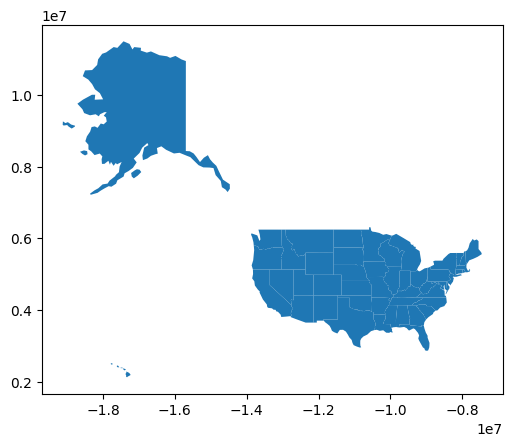

In [38]:
states.plot()